# MNIST Classification

This dataset contains 70,000 small images of handwritten digits. The data set includes labels indicating which digit the image represents.

### Setup

In [86]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
import matplotlib.pyplot as plt
import numpy as np

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

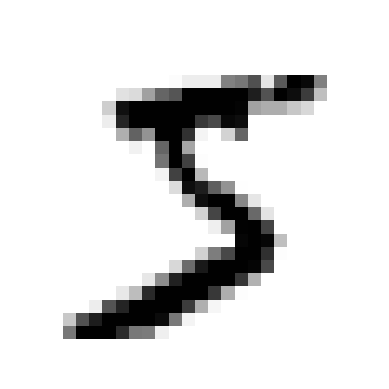

In [8]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

Split data into train and test sets

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Train binary classifier

In [11]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
np.unique(y_train, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

### Performance measures

#### Cross validation

In [15]:
# Accuracy

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [16]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [18]:
# Confusion matrices
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Precision: accuracy of positive predictions (TP / (FP + TP))

In [20]:
precision = precision_score(y_train_5, y_train_pred)
print(precision)

0.8370879772350012


Recall (aka sensitivity or true positive ratio): ratio of positive instances that are correctly detected

In [21]:
recall = recall_score(y_train_5, y_train_pred)
print(recall)

0.6511713705958311


F1 score: harmonic mean or precision and recall (gives more weight to low values)

In [22]:
f1_score_5 = f1_score(y_train_5, y_train_pred)
print(f1_score_5)

0.7325171197343847


Precision/recall tradeoff

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [25]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

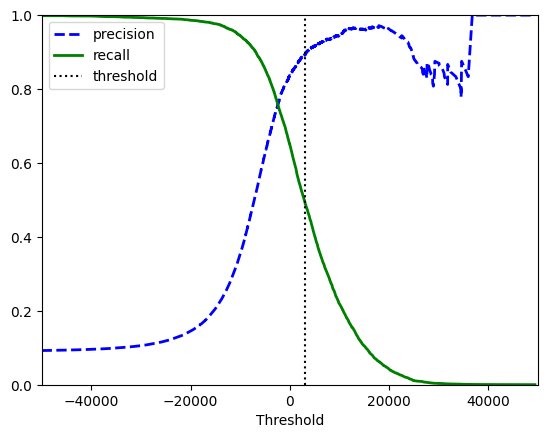

In [26]:
plt.plot(thresholds, precisions[:-1], 'b--', linewidth=2, label="precision")
plt.plot(thresholds, recalls[:-1], 'g-', linewidth=2, label="recall")
plt.vlines(3000, 0, 1.0, "k", "dotted", label='threshold')
plt.axis([-50000, 50000, 0, 1])
plt.xlabel("Threshold")
plt.legend()
plt.show()

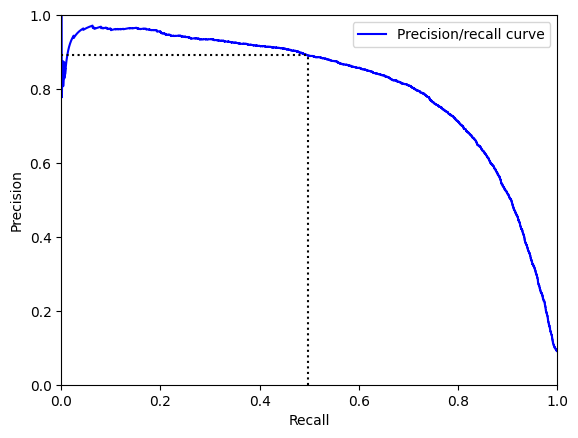

In [27]:
idx = (thresholds >= 3000).argmax()  # first index ≥ threshold
plt.plot(recalls, precisions, "b-", label="Precision/recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.axis([0, 1, 0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [28]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [29]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

#### ROC curve

In [31]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

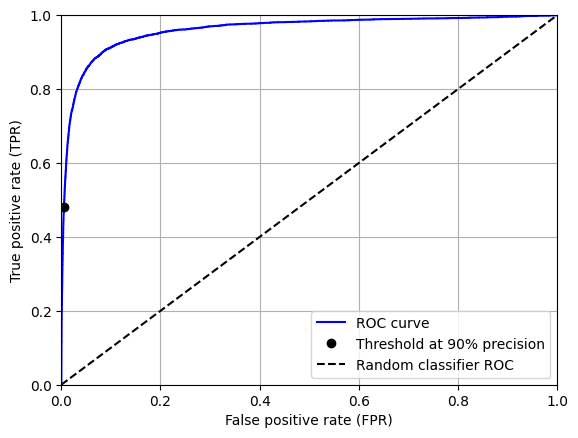

In [32]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
fpr90, tpr90 = fpr[idx_for_threshold_at_90], tpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, 'b-', label='ROC curve')
plt.plot(fpr90, tpr90, "ko", label="Threshold at 90% precision")
plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier ROC")
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend()
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

The ROC curve looks good, but this is because there are few positives (5s) compared to the negative class. In this situation, the PR curve is prefered for evaluating the model.

Random forest classifier

In [34]:
forest_clf = RandomForestClassifier(random_state=42)

In [35]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [36]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [37]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

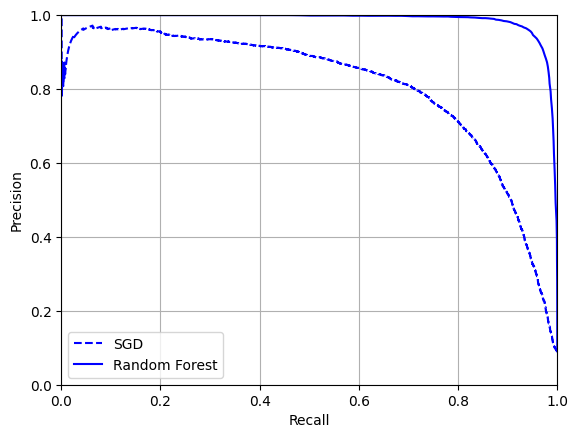

In [38]:
plt.plot(recalls, precisions, 'b--', label = "SGD")
plt.plot(recalls_forest, precisions_forest, 'b-', label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.legend()
plt.grid()
plt.show()

In [39]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [41]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [42]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

### Multiclass classification

In [43]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [44]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [46]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [47]:
svm_clf.classes_[class_id]

'5'

In [48]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,estimator,SVC(random_state=42)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


In [49]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [50]:
len(ovr_clf.estimators_)

10

In [51]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [52]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error analysis

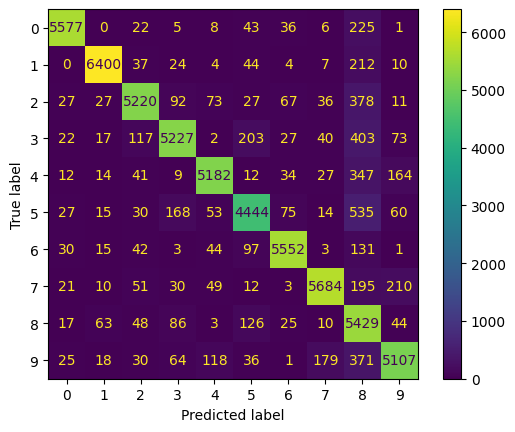

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

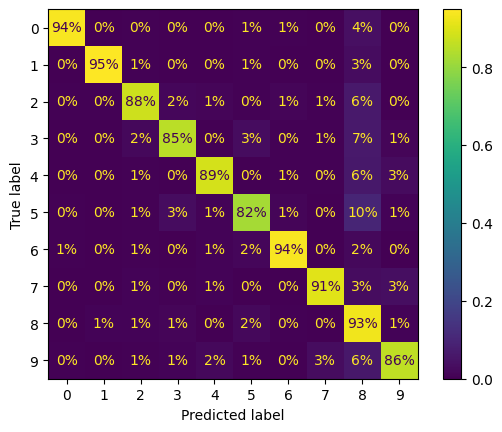

In [56]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

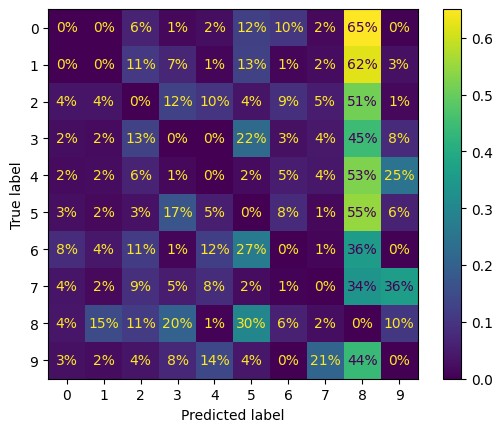

In [57]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")

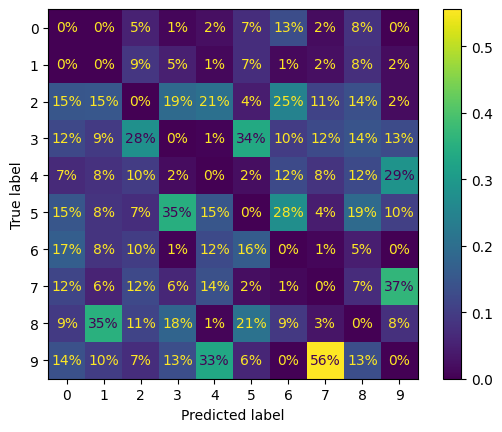

In [59]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%")

Analyzing individual errors can be a good way to gain insights into what the classifier is doing and why it is failing.

In [60]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

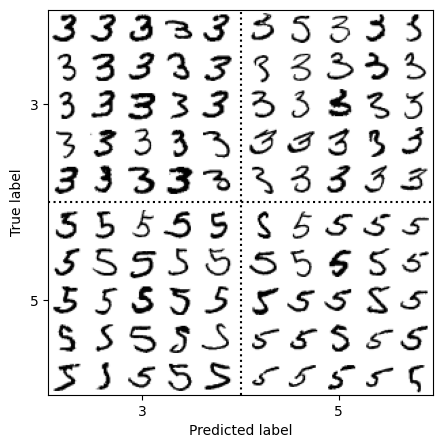

In [76]:
size = 5
pad = 0.2
plt.figure(figsize=(size,size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28,28), cmap='binary', extent=(x, x+1, y, y+1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()



### Multilabel classification

In [78]:
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [82]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [84]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [85]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9764102655606048

In [87]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

,estimator,SVC()
,order,None
,cv,3
,chain_method,'predict'
,random_state,42
,verbose,False
,base_estimator,'deprecated'
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [88]:
chain_clf.predict([some_digit])

array([[0., 1.]])

### Multioutput classification

A generalization of the multilabel classification where each label can be multiclass (more than two possible values).

In [90]:
# Add noice to MNIST pixel intensities
np.random.seed(42)
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

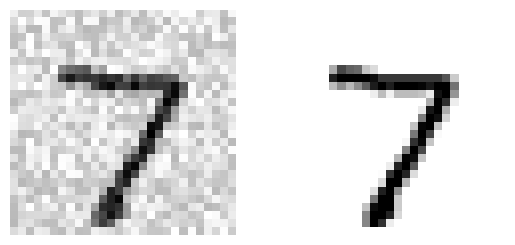

In [94]:
# take a look at a digit with noise
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

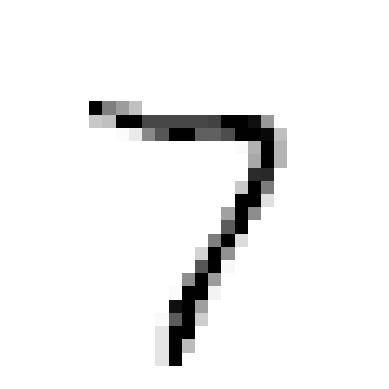

In [95]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

### Exercise 1 - MNIST classifier with over 97% accuracy

Start with a K-Nearest Neighbors classifier and measure its performance on the test set.

In [98]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_train, y_train)
baseline_accuracy

Close! Try tuning hyperparameters using grid search

In [101]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform', 'distance'],
     'n_neighbors': [3, 4, 5, 6]
     }]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10000], y_train[:10_000])


,estimator,KNeighborsClassifier()
,param_grid,"[{'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,4


In [102]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [103]:
grid_search.best_score_

np.float64(0.9441999999999998)

In [104]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_train, y_train)
tuned_accuracy

1.0